In [1]:
from __future__ import division

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import roc_curve, auc

import scipy.io as sio

/Users/luca/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [116]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Amp = pd.read_csv('./Data/Amp10.csv',header=None)

In [117]:
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [103]:
#Subjtype: 0 = Amputee, 1 = Healthy , 2 = Healthy outdoor
Healthy.head(5)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,-0.135490,0.023986,-0.22209,-0.034934,0.026296,0.061168,...,1.3975,1.0539,1.371,0.57013,0.042151,0.040205,0.036391,0.082633,0.057698,0.142730
1,1,1,1,3,-0.116930,0.041788,-0.25966,-0.036706,0.028857,0.069082,...,1.0056,-1.0666,1.371,0.59226,0.044890,0.055954,0.064699,0.077030,0.105940,0.130800
2,1,1,1,3,-0.095297,-0.009186,-0.26274,-0.031153,0.019380,0.071339,...,1.5987,2.0886,1.371,0.76639,0.050949,0.099145,0.054502,0.070348,0.107280,0.145240
3,1,1,1,4,-0.131590,0.012601,0.36066,-0.030360,0.038864,0.070713,...,2.0909,4.4104,1.371,0.51069,0.035452,0.046974,0.043586,0.073470,0.071604,0.098844
4,1,1,1,4,-0.174220,0.002581,0.33938,-0.049466,0.017201,0.068173,...,2.0293,4.1421,1.371,0.50332,0.045742,0.077608,0.067755,0.079449,0.131450,0.085266


In [5]:
print len(Healthy)
print len(Amp)

6652
2180


In [6]:
print ('N subjects Healthy: %s'%(len(Healthy.SubjID.unique())))
print ('N subjects Amp: %s'%(len(Amp.SubjID.unique())))
print Healthy.Subjtype.unique()
print Amp.Subjtype.unique()

N subjects Healthy: 10
N subjects Amp: 7
[1 2]
[0]


In [7]:
#Healthy
print ('Nfalls = %s')%(len(Healthy[Healthy.Falltype<9]))
print ('Nactivities = %s')%(len(Healthy[Healthy.Falltype==9]))

Nfalls = 6337
Nactivities = 315


In [8]:
#Amp
print ('Nfalls = %s')%(len(Amp[Amp.Falltype<9]))
print ('Nactivities = %s')%(len(Amp[Amp.Falltype==9]))

Nfalls = 1873
Nactivities = 307


In [9]:
#selecting cols by index
Healthy.iloc[1:5, 0:4]

,SubjID,Loc,Subjtype,Falltype
1,1,1,1,3
2,1,1,1,3
3,1,1,1,4
4,1,1,1,4


# Train on healthy and test on amputees

In [10]:
#transform to binary class
Xtr = Healthy.iloc[:,4:].as_matrix()
ytr = Healthy.Falltype.as_matrix()
Xte = Amp.iloc[:,4:].as_matrix()
yte = Amp.Falltype.as_matrix()
ytr[ytr < 9] = 1
ytr[ytr == 9] = 0
yte[yte < 9] = 1
yte[yte == 9] = 0

In [11]:
print Xtr.shape
print np.unique(ytr)
print Xte.shape
print np.unique(yte)

(6652, 1211)
[0 1]
(2180, 1211)
[0 1]


In [12]:
forest = RandomForestClassifier(n_estimators=50,random_state=10)
forest.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [13]:
importance = forest.feature_importances_
print(importance)
indices = np.argsort(importance)
importance_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
print(importance_std)

[  1.85748464e-04   2.16391737e-04   8.30112513e-04 ...,   0.00000000e+00
   7.37234140e-04   6.20178579e-05]
[ 0.00074738  0.001124    0.00298893 ...,  0.          0.00300895
  0.00043413]


In [14]:
importance_norm = importance/np.max(importance)

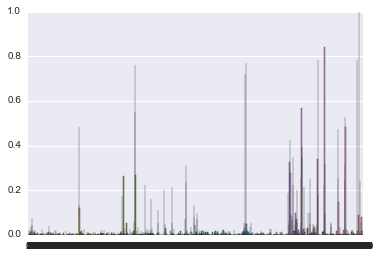

In [15]:
#using Seaborn
ax = sns.barplot(x=indices,y=importance_norm[indices])
sns.set_context("paper")
plt.figure(figsize=(8,6))

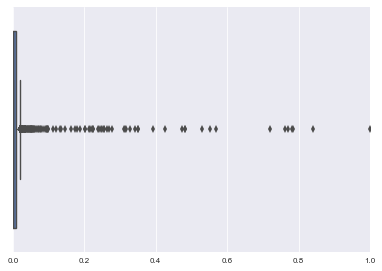

In [16]:
ax = sns.boxplot(importance_norm)
plt.figure(figsize=(8,6))

In [17]:
qc = np.percentile(importance_norm,[75])
print 1.5*qc

[ 0.01155159]


In [18]:
#indmax = np.argwhere(importance_norm >= 1.5*qc)
indmax = np.argwhere(importance_norm >= 0.1)
indmax = indmax.reshape(-1)
print len(indmax)
print indmax

47
[ 183  184  185  338  344  386  387  388  423  445  470  492  520  569  570
  599  785  786  940  945  946  948  956  957  972  986  988  989  990  996
 1018 1046 1047 1048 1070 1071 1072 1120 1121 1122 1144 1145 1146 1147 1190
 1195 1200]


In [19]:
forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)
forest.fit(Xtr[:,indmax],ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [20]:
ypred = forest.predict(Xte[:,indmax])
yscore = forest.predict_proba(Xte[:,indmax])
yscore = yscore[:,1]

In [24]:
#acc = np.sum(ypred==yte)/len(ypred)
#print('Acc = %.3f')%acc
fprHA, tprHA, thresholdsHA = metrics.roc_curve(yte, yscore, pos_label=1)
roc_aucHA = auc(fprHA, tprHA)
print('AUC = %.3f'%roc_auc)

AUC = 0.991


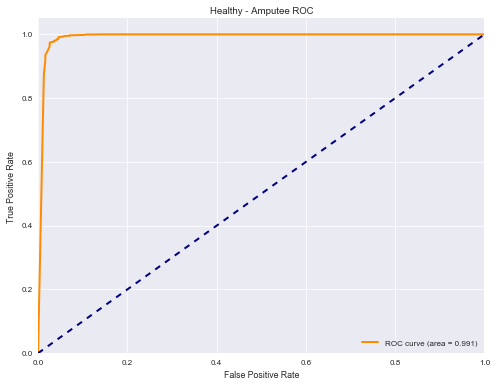

In [27]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - Amputee ROC')
plt.legend(loc="lower right")
sns.set_context('poster')

## LOSO CV on Healthy

In [118]:
from sklearn.model_selection import LeaveOneGroupOut

In [119]:
#indoor falls 
print np.sort(Healthy[Healthy.Subjtype == 1].SubjID.unique())
print np.sort(Healthy[Healthy.Subjtype == 2].SubjID.unique())

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  4  5  6  7  8  9 10]


In [120]:
#drop subject 3 
Healthy = Healthy[Healthy.SubjID!=3]
Healthy.SubjID.unique()

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10])

In [121]:
Healthy.shape

(6236, 1215)

In [122]:
#binarize labels
X = Healthy.iloc[:,4:].as_matrix()
y = Healthy.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0

In [123]:
np.unique(y)

array([0, 1])

In [124]:
print X.shape
print y.shape

(6236, 1211)
(6236,)


In [125]:
groups = Healthy.SubjID.as_matrix()
print groups.shape
print np.unique(groups)

(6236,)
[ 1  2  4  5  6  7  8  9 10]


In [126]:
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

9

In [127]:
indmax #602 gyro features + 602 accelerometer

array([ 183,  184,  185,  338,  344,  386,  387,  388,  423,  445,  470,
        492,  520,  569,  570,  599,  785,  786,  940,  945,  946,  948,
        956,  957,  972,  986,  988,  989,  990,  996, 1018, 1046, 1047,
       1048, 1070, 1071, 1072, 1120, 1121, 1122, 1144, 1145, 1146, 1147,
       1190, 1195, 1200])

In [128]:
for train_index, test_index in subj.split(X, y, groups):
    Xtr,Xte = X[train_index],X[test_index]
    ytr = y[train_index]
    Xtr,Xte = Xtr[:,indmax],Xte[:,indmax]
    print Xtr.shape,Xte.shape,ytr.shape

(5540, 47) (696, 47) (5540,)
(5549, 47) (687, 47) (5549,)
(5680, 47) (556, 47) (5680,)
(5504, 47) (732, 47) (5504,)
(5502, 47) (734, 47) (5502,)
(5529, 47) (707, 47) (5529,)
(5614, 47) (622, 47) (5614,)
(5460, 47) (776, 47) (5460,)
(5510, 47) (726, 47) (5510,)


AUC = 0.9994, Sens = 0.9985, Spec = 0.9583
AUC = 0.9866, Sens = 0.9851, Spec = 0.7333
AUC = 0.9999, Sens = 1.0000, Spec = 0.9444
AUC = 0.9992, Sens = 1.0000, Spec = 0.8333
AUC = 0.9984, Sens = 1.0000, Spec = 0.9143
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9944, Sens = 0.9986, Spec = 0.8493
AUC = 0.9994, Sens = 0.9928, Spec = 0.9722
mean AUC = 0.997 (+/- 0.008)
mean Sens = 0.997 (+/- 0.010)
mean Spec = 0.912 (+/- 0.169)


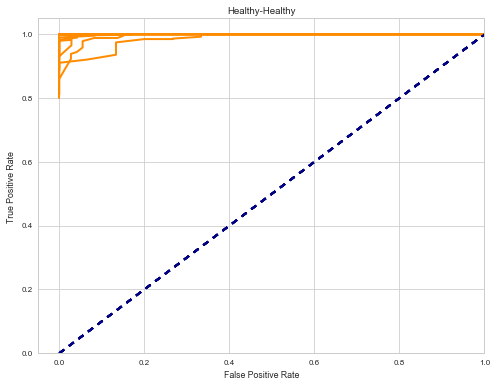

In [443]:
sns.set_style('whitegrid')
sns.set_context('paper')

AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
thr = np.linspace(0,1,21)
thr = thr[::-1]

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]

    #acc = np.sum(ypred==yte)/len(ypred)
    #print('Acc = %.4f')%acc
    
#    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1,drop_intermediate=False
    #compute ROC at fixed thresholds (to plot error bars)
    fpr=[]; tpr=[]
    for t in thr:
        inds = np.asarray(np.where(yscore>=t)) #all data points scored positive
        ypred_t = np.zeros_like(ypred); ypred_t[inds] = 1 
        fpr_t = sum((ypred_t==1) & (yte==0)) / sum(yte==0)
        tpr_t = sum((ypred_t==1) & (yte==1)) / sum(yte==1)
        fpr.append(fpr_t); tpr.append(tpr_t) 
        
        #compute Sens and Spec
        if t == 0.5:
            Sens = tpr_t; Spec = 1-fpr_t
        
    fpr = np.asarray(fpr); tpr = np.asarray(tpr)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f, Sens = %.4f, Spec = %.4f'%(roc_auc,Sens,Spec))    
    AUC_all.append(roc_auc)
    tpr_all.append(tpr); fpr_all.append(fpr);
    Sens_all.append(Sens); Spec_all.append(Spec)
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy-Healthy')
#plt.legend(loc="lower right")

print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))
print('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all))
print('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all))



In [446]:
tprmu = np.mean(np.asarray(tpr_all),axis=0)
tprstd = np.std(np.asarray(tpr_all),axis=0)
fprmu = np.mean(np.asarray(fpr_all),axis=0)
fprstd = np.std(np.asarray(fpr_all),axis=0)

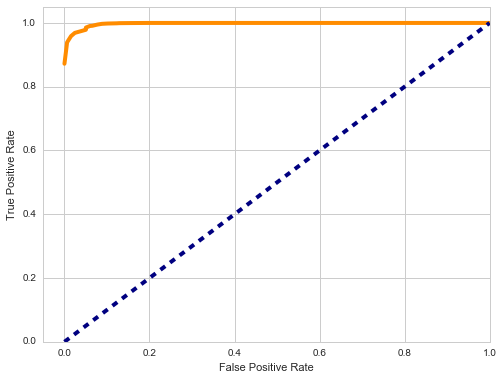

In [504]:
plt.figure(figsize=(8,6))
lw = 4
plt.plot(fprmu, tprmu, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [452]:
print fprmu
print tprmu

[ 0.          0.00621874  0.015478    0.02440748  0.05040045  0.05040045
  0.05040045  0.05961743  0.06570571  0.07772161  0.08830362  0.10163582
  0.1229146   0.12913335  0.13065542  0.15691475  0.19849874  0.23704684
  0.28326039  0.39530025  1.        ]
[ 0.87199461  0.9391387   0.95870343  0.96886324  0.97858724  0.98282702
  0.9854954   0.99034558  0.99117036  0.99495381  0.99721801  0.99818553
  0.99884691  0.99933862  0.99933862  0.99966931  1.          1.          1.
  1.          1.        ]


In [494]:
x = np.linspace(0,15,31)
print x.shape
data=np.sin(x)+np.random.rand(10,31)
print data.shape

(31,)
(10, 31)


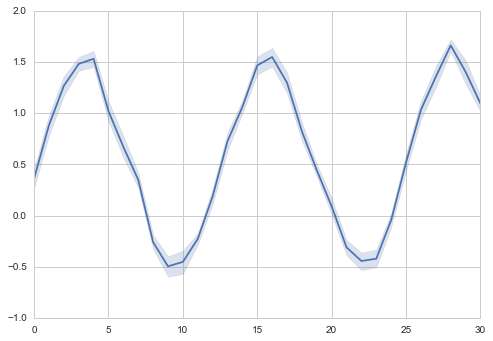

In [500]:
sns.set_context('notebook')
ax = sns.tsplot(data=data)

In [456]:
data.shape

(10, 31)

In [441]:
fprmu = np.mean(fpr_all,axis=0)
tpr = np.mean(tpr_all,axis=0)

In [442]:
fpr_all


array([ 0.        ,  0.00621874,  0.015478  ,  0.02440748,  0.05040045,
        0.05040045,  0.05040045,  0.05961743,  0.06570571,  0.07772161,
        0.08830362,  0.10163582,  0.1229146 ,  0.12913335,  0.13065542,
        0.15691475,  0.19849874,  0.23704684,  0.28326039,  0.39530025,  1.        ])

In [426]:
#compute mean sensitivity and specificity (thr = 0.5)
t = np.where(thr==0.5)[0][0]
for l in range(len(tpr_all)):
    np.
    print tpr_all[l][t]

0.998511904762
0.985119047619
1.0
1.0
1.0
1.0
1.0
0.998577524893
0.992753623188


In [395]:
auc(fprmu,tprmu,reorder=True)

0.1935277189252263

In [44]:
print('mean AUC (w feature sel) = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))


mean AUC (w feature sel) = 0.996 (+/- 0.015)


## Use jittered data

In [62]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [63]:
Healthy.head(3)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,-0.135490,0.023986,-0.22209,-0.034934,0.026296,0.061168,...,1.3975,1.0539,1.371,0.57013,0.042151,0.040205,0.036391,0.082633,0.057698,0.14273
1,1,1,1,3,-0.116930,0.041788,-0.25966,-0.036706,0.028857,0.069082,...,1.0056,-1.0666,1.371,0.59226,0.044890,0.055954,0.064699,0.077030,0.105940,0.13080
2,1,1,1,3,-0.095297,-0.009186,-0.26274,-0.031153,0.019380,0.071339,...,1.5987,2.0886,1.371,0.76639,0.050949,0.099145,0.054502,0.070348,0.107280,0.14524


In [64]:
print ('N falls = %s'%(len(Healthy[Healthy.Falltype < 9])))
print ('N act = %s'%(len(Healthy[Healthy.Falltype == 9]))) #act
print ('Total = %s'%len(Healthy))

N falls = 6337
N act = 315
Total = 6652


In [65]:
print len(Amp[Amp.Falltype < 9])
print len(Amp[Amp.Falltype == 9]) #act
print len(Amp)

1873
307
2180


### CV on Healthy

In [55]:
X = Healthy.iloc[:,4:].as_matrix()
y = Healthy.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0
groups = Healthy.SubjID.as_matrix()
print groups.shape
print np.unique(groups)
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

(6672,)
[ 1  2  3  4  5  6  7  8  9 10]


10

In [56]:
X.shape

(6672, 1211)

AUC = 0.9997
AUC = 0.9904
AUC = 0.9772
AUC = 1.0000
AUC = 1.0000
AUC = 0.9987
AUC = 1.0000
AUC = 1.0000
AUC = 0.9862
AUC = 0.9984


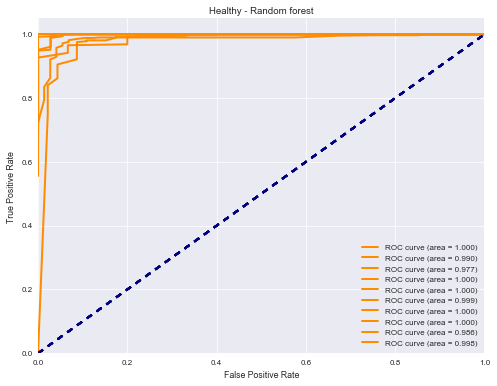

In [58]:
AUC_all = []; ytrue_all = []; ypred_all = []; fpidx = []
tridx = []; teidx = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    tridx.append(train_index)
    teidx.append(test_index)
    #selct features
    #Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    ypred_all.append(ypred)
    ytrue_all.append(yte)    
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
    fpidx.append(np.where((ypred == 1) & (yte == 0)))
    #print('Acc = %.4f')%acc
    
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - Random forest')
plt.legend(loc="lower right")

In [59]:
print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))

mean AUC = 0.995 (+/- 0.015)


In [60]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fall','Fall'], rotation=45)
    plt.yticks(tick_marks, ['Non-Fall','Fall'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[[ 10   2]
 [  0 720]]
[[ 0.83333333  0.16666667]
 [ 0.          1.        ]]


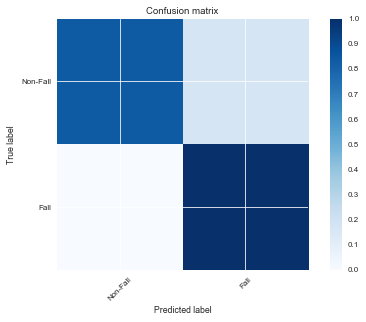

In [61]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(ytrue_all[4],ypred_all[4])
print cmat
totals = cmat.sum(axis=1)
totals = totals.T
totals = np.expand_dims(totals,axis=1)
totals = np.tile(totals,(1,2))
cmat_norm = cmat/totals
print cmat_norm
plot_confusion_matrix(cmat_norm)

In [ ]:
teidx[4].shape

In [ ]:
len(fpidx[4][0])

In [ ]:
fpidx[4][0]

In [ ]:
for idx in fpidx[4]:
    fpidx4 = teidx[4][idx]

In [ ]:
fpidx4

### Amputees
**Note: SubjID 2 does not have activities**

In [ ]:
Amp[Amp.SubjID ==2].Falltype.unique()

In [ ]:
Amp = Amp[Amp.SubjID != 2] #drop subj 2

In [ ]:
X = Amp.iloc[:,4:].as_matrix()
y = Amp.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0
groups = Amp.SubjID.as_matrix()
print groups.shape
print np.unique(groups)
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

In [ ]:
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    #Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
    #print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Amputees - Random forest')
plt.legend(loc="lower right")

In [ ]:
# try xgboost
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=10)

In [ ]:
#LOSO CV
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]

    xgb1.fit(Xtr,ytr)
    ypred = xgb1.predict(Xte)
    yscore = xgb1.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
#    print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - XGboost forest')
plt.legend(loc="lower right")

In [ ]:
print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))

See here on XGBoost params
http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

as well as here
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
xgb1.get_params()

In [ ]:
xgb1.fit(Xtr,ytr,eval_metric='auc')

In [ ]:
pred = xgb1.predict(Xte)

In [ ]:
pred_prob = xgb1.predict_proba(Xte)

In [ ]:
pred_prob.shape

In [ ]:
X = Xin.drop(['SubjID','Loc','Subjtype'],axis=1)
X.head(3)

In [ ]:
xgtrain = xgb.DMatrix(X,label='Falltype')
xgtest = xgb.DMatrix(Xte,label='Falltype')

In [ ]:
print xgtrain.num_col()
print xgtrain.num_row()
print xgtest.num_col()
print xgtest.num_row()

Look at the clips

In [ ]:
labels = sio.loadmat('./Data/accHealthy10.mat')

In [ ]:
acc = labels['acc']

In [ ]:
acc.shape

In [ ]:
i

In [ ]:
i = np.random.permutation(fpidx4)
i = i[0]
a = acc[i][0][:,1:]
plt.plot(a)

In [ ]:
np.where(Healthy.Falltype == 0)

In [ ]:
acc